In [99]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("rug-minds/parse-ego4d")

params_per_model = {
    "avsolatorio/GIST-small-Embedding-v0": 33.36e6,
    "Alibaba-NLP/gte-base-en-v1.5": 136.776192e6,
    "Alibaba-NLP/gte-large-en-v1.5": 434.139136e6,
    "google/mobilebert-uncased": 24.581888e6,
    "google/gemma-2b-it": -1,
}
embedding_sizes = {
    "avsolatorio/GIST-small-Embedding-v0": 384,
    "Alibaba-NLP/gte-base-en-v1.5": 768,
    "Alibaba-NLP/gte-large-en-v1.5": 1024,
    "google/mobilebert-uncased": 512,
}
N_CLASSES = 6

rows = []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    row = {
        "name": run.name,
        'state': run.state,
        'model_name': run.config.get('model_name', None),
        'layer_sizes': run.config.get('layer_sizes', None),
        'use_narrations': run.config.get('use_narrations', None),
        "summary": run.summary._json_dict,
        "created_at": run.created_at,
        "tags": run.tags,
        "id": run.id
    }
    for k, v in run.summary._json_dict.items():
        k = k.replace("test/_accuracy", "test_accuracy")
        k = k.replace("eval/_accuracy", "val_accuracy")
        k = k.replace("train/_accuracy", "train_accuracy")
        row[k] = v

    if 'gemma' not in row['model_name']:
        row['n_params'] = params_per_model[row['model_name']]
        layer_sizes = row['layer_sizes']
        if len(layer_sizes) > 0:
            size_pre = embedding_sizes[row['model_name']]
            for ls in layer_sizes:
                row['n_params'] += size_pre * ls
                size_pre = ls
            row['n_params'] += size_pre * N_CLASSES
        else:
            row['n_params'] += embedding_sizes[row['model_name']] * N_CLASSES
    else:
        row['n_params'] = run.config.get("model/num_parameters", -1)

    row['n_params (M)'] = row['n_params'] / 1e6
    if "invalid" not in run.tags and run.state not in ['failed', 'crashed']:
        rows.append(row)
    # # .config contains the hyperparameters.
    # #  We remove special values that start with _.
    # config_list.append(
    #     {k: v for k,v in run.config.items()
    #       if not k.startswith('_')})

runs_df = pd.DataFrame(rows)

In [100]:
runs_df

,name,state,model_name,layer_sizes,use_narrations,summary,created_at,tags,id,_wandb,...,eval/runtime,train/grad_norm,eval/accuracy,train_samples_per_second,test/_loss,train/epoch,train_runtime,train/global_step,eval/samples_per_second,test/_samples_per_second
0,legendary-planet-33,finished,avsolatorio/GIST-small-Embedding-v0,[],False,"{'_wandb': {'runtime': 15935}, '_runtime': 159...",2024-07-31T11:28:53,[],bs2nyw0u,{'runtime': 15935},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,unique-smoke-34,finished,avsolatorio/GIST-small-Embedding-v0,[512],False,"{'test_loss': 1.38930652264891, '_timestamp': ...",2024-07-31T11:29:00,[],2wpitjdz,{'runtime': 15093},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,divine-spaceship-36,finished,avsolatorio/GIST-small-Embedding-v0,"[512, 512]",False,"{'_step': 1069, 'val_loss': 1.319431122144063,...",2024-07-31T11:29:00,[],6dadnesx,{'runtime': 15823},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cool-sound-38,finished,avsolatorio/GIST-small-Embedding-v0,"[1024, 1024]",False,"{'batch_loss': 1.2988072633743286, 'val_accura...",2024-07-31T11:29:00,[],ubbzq0bf,{'runtime': 15751},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,deep-fire-44,finished,Alibaba-NLP/gte-base-en-v1.5,[],False,"{'batch_loss': 1.3398054838180542, 'train_loss...",2024-07-31T11:30:05,[],ve2zzs62,{'runtime': 16274},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,sweet-glade-48,finished,Alibaba-NLP/gte-base-en-v1.5,"[512, 512]",False,"{'train_loss': 1.2752354562839614, 'val_accura...",2024-07-31T12:14:05,[],hrz6v3pr,{'runtime': 18440},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,proud-terrain-47,finished,Alibaba-NLP/gte-base-en-v1.5,[512],False,"{'_step': 1069, '_wandb': {'runtime': 19205}, ...",2024-07-31T12:14:05,[],polo8sjt,{'runtime': 19205},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,lyric-bush-53,finished,google/mobilebert-uncased,[],False,"{'_wandb': {'runtime': 16761}, 'batch_loss': 1...",2024-07-31T12:17:45,[],q3bm6eom,{'runtime': 16761},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,upbeat-smoke-54,finished,google/mobilebert-uncased,[512],False,"{'_wandb': {'runtime': 17749}, '_runtime': 177...",2024-07-31T12:17:45,[],yehc1943,{'runtime': 17749},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,robust-breeze-55,finished,google/mobilebert-uncased,"[512, 512]",False,"{'_runtime': 18546.54593539238, 'test_loss': 2...",2024-07-31T12:17:52,[],34iyghle,{'runtime': 18545},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


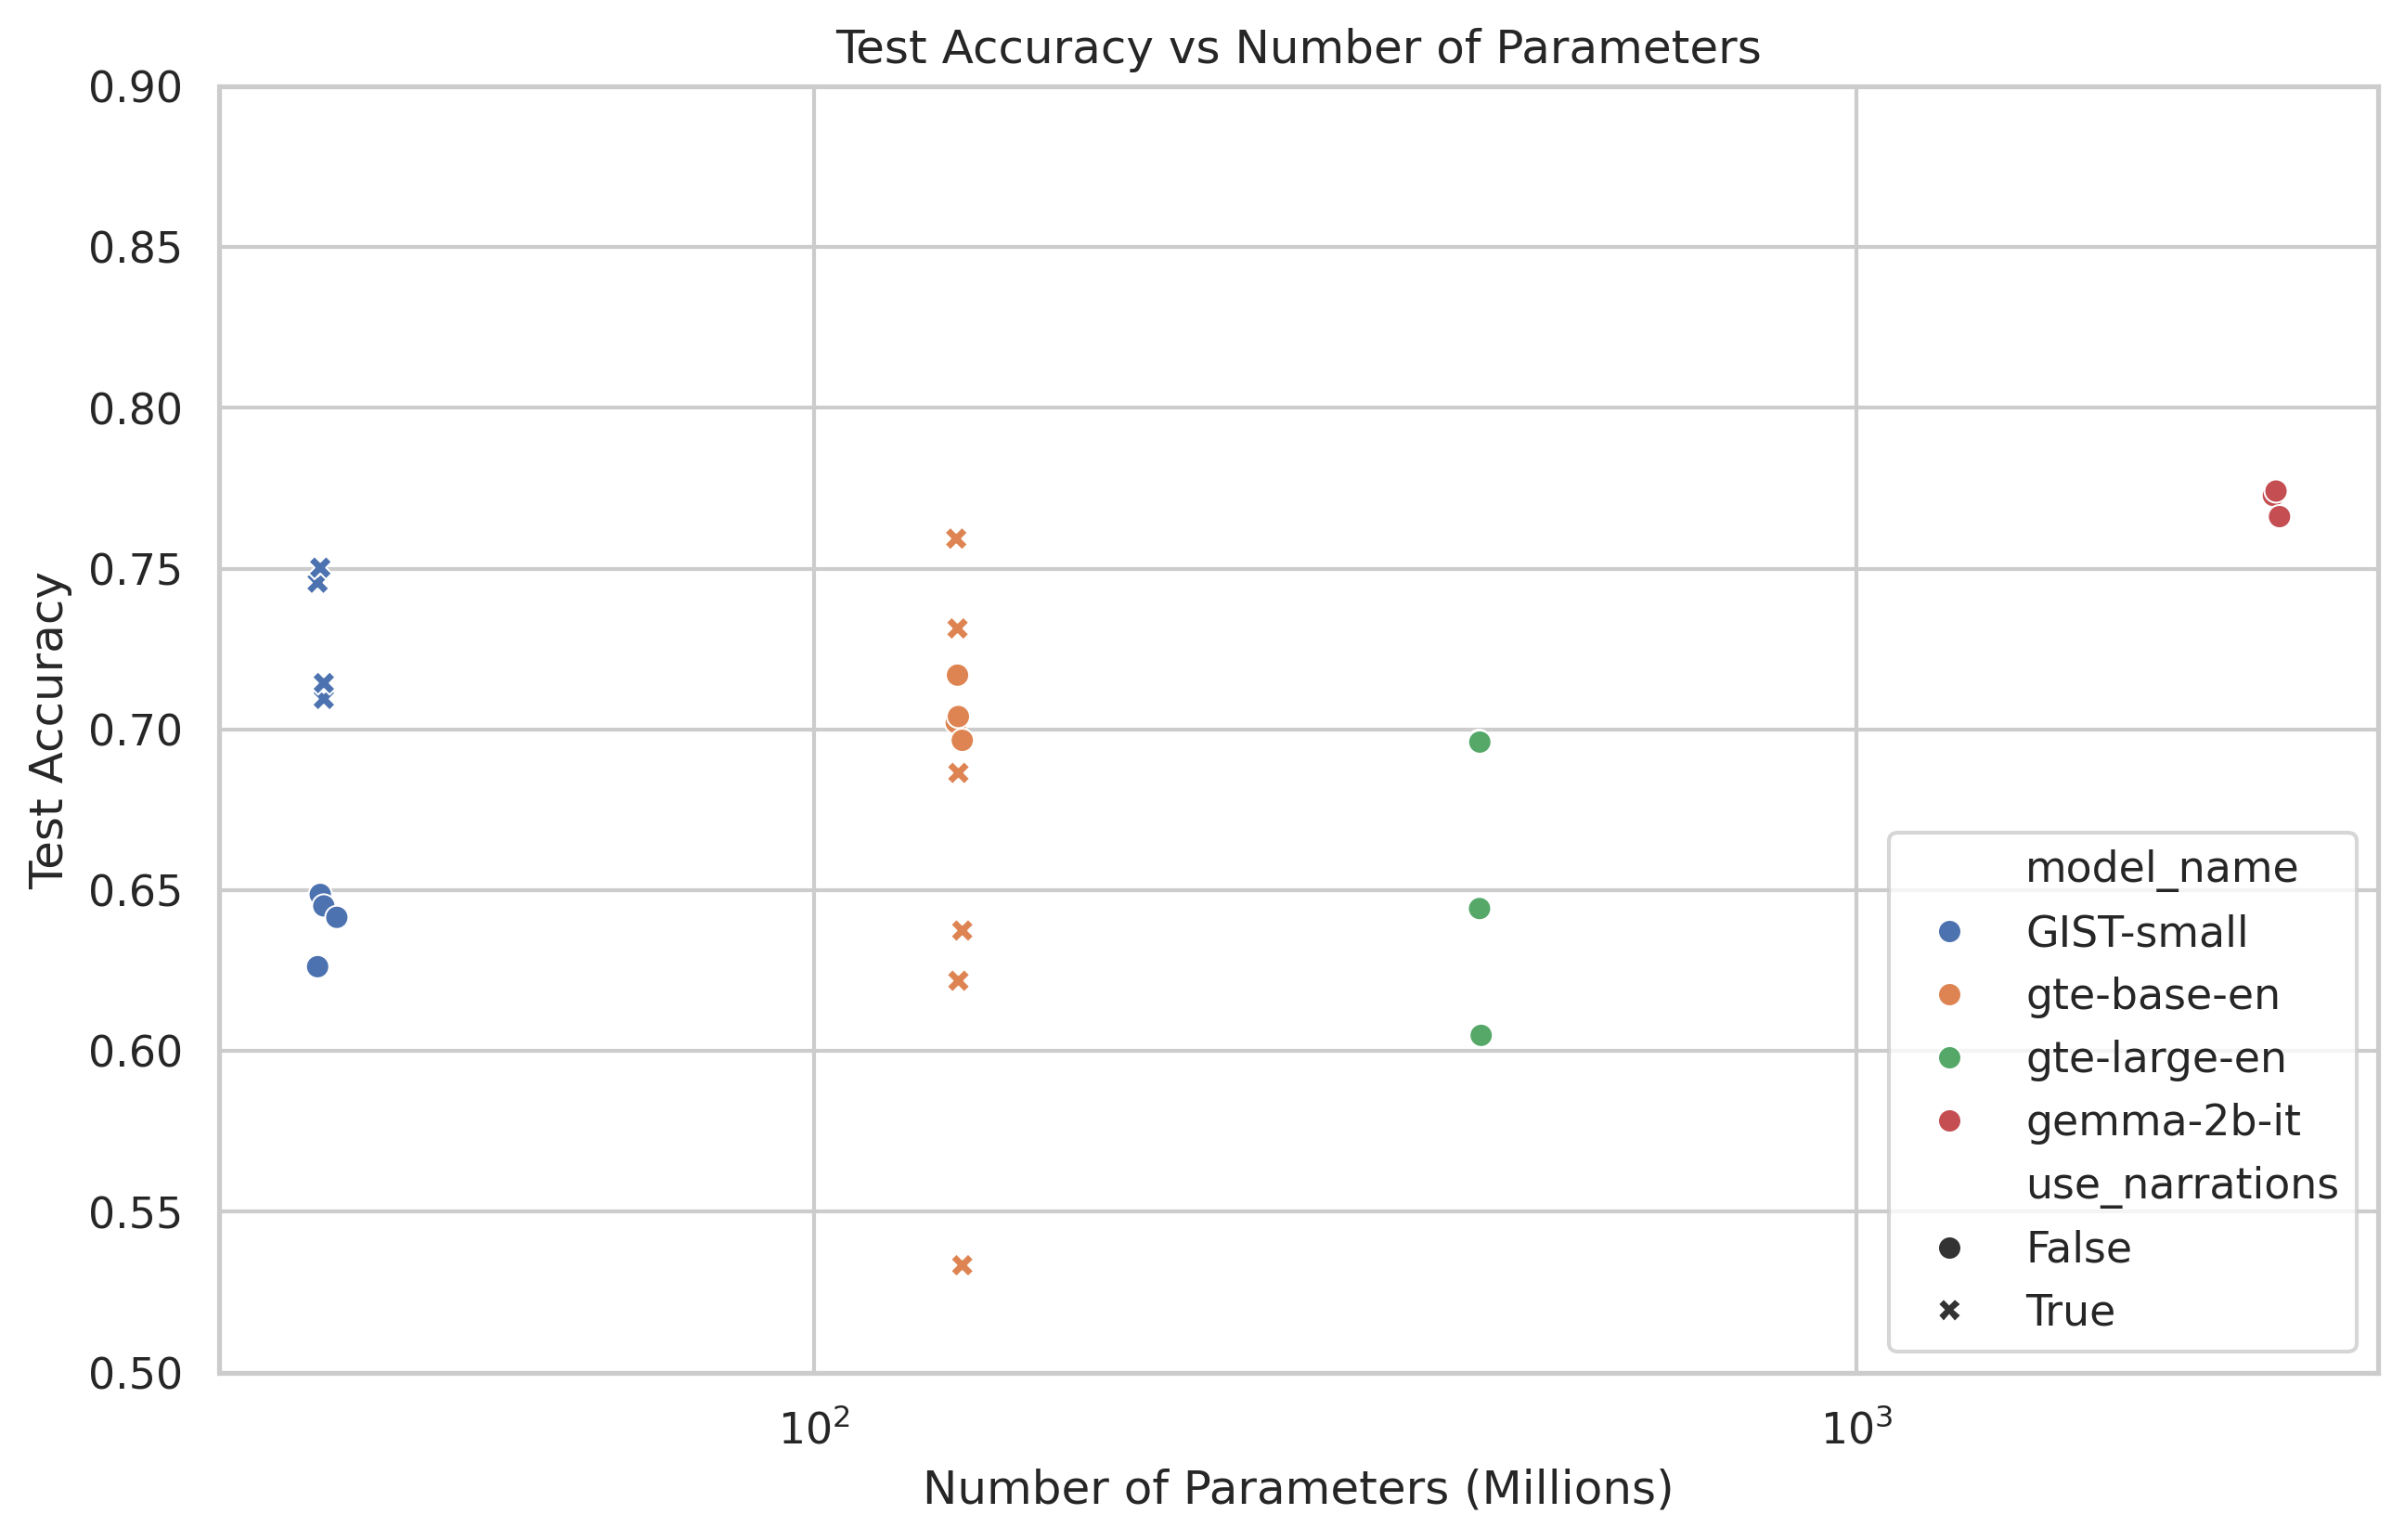

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6), dpi=300)
df = runs_df.copy()
df = df[df.test_accuracy > 0.5]
df['model_name'] = df['model_name'].str.split('/').str[1]
df['model_name'] = df['model_name'].str.replace("-Embedding-v0", "").str.replace("-v1.5", "")
sns.scatterplot(data=df, x='n_params (M)', y='test_accuracy', hue='model_name', style="use_narrations")
plt.xlabel('Number of Parameters (Millions)')
plt.ylabel('Test Accuracy')
plt.ylim(0.5, 0.9)
plt.xscale('log')
plt.title('Test Accuracy vs Number of Parameters')
plt.show()

In [54]:
runs_df.iloc[0].summary

{'train_accuracy': 0.7051947103090523,
 '_wandb': {'runtime': 15935},
 '_runtime': 15936.7199280262,
 'train_loss': 1.3530083281971583,
 'val_accuracy': 0.7163198247535597,
 'batch_loss': 1.3098729848861694,
 'stop_counter': 5,
 'best_val_loss': 1.3357096433639526,
 'test_accuracy': 0.6262322015334063,
 '_step': 1069,
 'val_loss': 1.3357096433639526,
 'test_loss': 1.4378318642747814,
 '_timestamp': 1722441269.7075691}

In [42]:
from transformers import AutoModel
for model_name in params_per_model.keys():
    model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
    print(model_name, model.num_parameters(), model.num_parameters()/1e6)

avsolatorio/GIST-small-Embedding-v0 33360000 33.36
Alibaba-NLP/gte-base-en-v1.5 136776192 136.776192
Alibaba-NLP/gte-large-en-v1.5 434139136 434.139136
google/mobilebert-uncased 24581888 24.581888


In [33]:
model.num_parameters()

24581888

In [34]:
24581888/1e6

24.581888

In [43]:
from utils import load_data
x = load_data()

108 NaNs dropped. 18252 left


In [46]:
x.Action.unique().__len__()

6